#  Q-learning

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Саттон Р.	С.,	Барто Э. Дж. Обучение с подкреплением: Введение. 2-е изд.
* https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/
* https://en.wikipedia.org/wiki/Q-learning
* https://www.baeldung.com/cs/epsilon-greedy-q-learning
* https://pythonprogramming.net/q-learning-reinforcement-learning-python-tutorial/
* https://www.datacamp.com/tutorial/introduction-q-learning-beginner-tutorial
* https://rubikscode.net/2021/07/20/introduction-to-double-q-learning/
* https://gymnasium.farama.org/api/wrappers/misc_wrappers/#gymnasium.wrappers.RecordVideo

## Задачи для совместного разбора

1\. Рассмотрите понятие Q-функции, ее применение для формирования политики агента и способов ее создания.

In [ ]:
import numpy as np

In [ ]:
actions = [0, 1]
states = [0, 1, 2]

q_table = np.random.uniform(0, 1, size=(len(states), len(actions)))
q_table.shape

(3, 2)

In [ ]:
current_state = 1
q_table[current_state].argmax()

0

In [ ]:
# np.digitize

## Задачи для самостоятельного решения

In [ ]:
!pip install gymnasium

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

<p class="task" id="1"></p>

1\. Обучите агента для игры в блэкджек (окружение `Blackjack-v1`), используя алгоритм Q-learning. Для создания таблицы Q-функции выясните размеры пространства состояния игры и количество возможных действий игрока и выведите эти значения на экран. Во время обучения несколько раз вычислите статистику за `print_every` последних эпизодов: количество выигранных и проигранных сессий. После завершения обучения визуализируйте полученные данные. Изучите, как выглядит Q-функция (в каких состояниях игрок будет брать карту, в каких - нет). Cыграйте `N=10000` игр, применяя стратегию, выведенную из обученной Q-функции, посчитайте и выведите на экран долю выигранных игр.

Cтратегия для выбора действия:
$$a_{t+1}(s_t) = argmax_aQ(s_t, a)$$

Правило обновления Q-функции:

![q-learning](https://wikimedia.org/api/rest_v1/media/math/render/svg/d247db9eaad4bd343e7882ec546bf3847ebd36d8)

- [ ] Проверено на семинаре

In [ ]:
from dataclasses import dataclass

@dataclass
class Config:
  discount: float = 0.95
  lr: float = 0.005
  n_episodes: float = 100_000
  print_every: int = 5000

In [ ]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm

class Agent:
  def __init__(self, env: gym.Env, config: Config) -> None:
    self.env = env
    self.config = config
    self._create_q_table()

  def _create_q_table(self):
    # напишите код для создания таблицы Q-функции
    # для окружения Blackjack должен получиться массив 32x11x2x2
    self.q_table = np.random.normal(0, 1, size=(32, 11, 2, 2))

  def get_action(self, state: np.ndarray) -> int:
    # найдите и верните индекс максимума Q-функции для состояния state
    # обратите внимание, что максимумов может быть несколько
    return np.argmax(self.q_table[state])

  def update_q_table(self, state: np.ndarray, new_state: np.ndarray, reward: float, action: int, done: bool) -> None:
    # напишите код для обновления Q-функции согласно правилу выше
    # если эпизод закончен, то будущая награда равна 0
    gamma = self.config.discount
    lr = self.config.lr
    q_future = (not done) * np.max(self.q_table[new_state])
    self.q_table[state][action] = (1 - lr) * self.q_table[state][action] + lr * (reward + gamma * q_future)

  def run_episode(self) -> float:
    done = False
    state, info = self.env.reset()
    while not done:
      action = self.get_action(state)
      new_state, reward, terminated, truncated, info = self.env.step(action)
      done = terminated or truncated
      self.update_q_table(state, new_state, reward, action, done)
      state = new_state

      if done:
        return reward

  def train(self):
    # допишите код для сбора статистики
    ep_rewards = []
    stats = []
    for ep in tqdm(range(self.config.n_episodes)):
      reward = self.run_episode()
      ep_rewards.append(reward)
      if (ep+1) % self.config.print_every == 0:
        rew = np.array(ep_rewards)
        stats.append(rew[rew == 1].sum() / self.config.print_every)
        ep_rewards = []
    return stats

100%|██████████| 100000/100000 [00:17<00:00, 5587.34it/s]


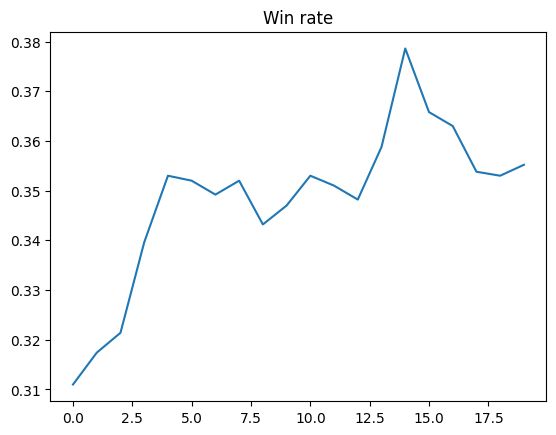

In [ ]:
env = gym.make('Blackjack-v1', natural=False, sab=False)
env = TransformObservation(env, lambda obs: th.tensor(obs), env.observation_space)

agent = Agent(env, Config)
st = agent.train()
plt.plot(st)
plt.title('Win rate');

In [ ]:
def visualize_q_func(q_func):
  playersum = np.arange(11, 21)
  dealersum = np.arange(1, 11)
  pairs = np.array(np.meshgrid(playersum, dealersum)).T.reshape(-1, 2)
  res_noace = np.zeros((32, 12))
  res_ace = np.zeros((32, 12))
  for pair in pairs:
    p_sum, d_sum = pair
    action1 = np.argmax(q_func[p_sum, d_sum, 0])
    action2 = np.argmax(q_func[p_sum, d_sum, 1])
    res_noace[p_sum, d_sum] = action1
    res_ace[p_sum, d_sum] = action2

  res_noace = res_noace[11:21, 1:-1]
  res_ace = res_ace[11:21, 1:-1]
  dct_res = {'no usable ace (0 - Stick, 1 - Hit)': res_noace,
            'usable ace (0 - Stick, 1 - Hit)': res_ace}
  fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
  for idx, (title, res) in enumerate(dct_res.items()):
    sns.heatmap(res.T, annot=True, xticklabels=playersum+1, yticklabels=dealersum+1, ax=ax[idx], cbar=False)
    ax[idx].set_ylabel('dealer sum')
    ax[idx].set_xlabel('player_sum')
    ax[idx].set_title(title)
  plt.show();

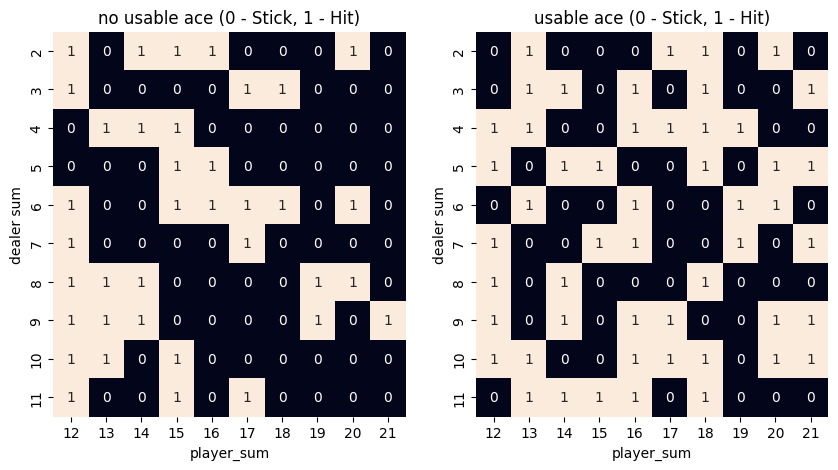

In [ ]:
visualize_q_func(agent.q_table)

In [ ]:
def play_games(ENV, policy, N=10_000):
  wins = 0
  for ep in range(N):
    done = False
    state, info = ENV.reset()
    while not done:
      action = policy.get_action(state)
      state, reward, terminated, truncated, info = ENV.step(action)
      done = terminated or truncated
      if reward == 1:
        wins += 1
  print(f'winrate: {wins / N}')

In [ ]:
play_games(env, agent)

winrate: 0.3598


<p class="task" id="2"></p>

2\. Повторите решение предыдущей задачи, используя алгоритм $\epsilon$-greedy Q-learning. Исследуйте, как гиперпараметры и способ инициализации значений Q-функции влияют на результат.

Cтратегия для выбора действия:
1. Сгенерировать число $p$ из $U(0, 1)$;
2. Если $p < \epsilon$, то выбрать действие случайным образом;
3. В противном случае $a_{t+1}(s_t) = argmax_aQ(s_t, a)$.

Правило обновления Q-функции:
![q-learning](https://wikimedia.org/api/rest_v1/media/math/render/svg/d247db9eaad4bd343e7882ec546bf3847ebd36d8)

- [ ] Проверено на семинаре

In [ ]:
from dataclasses import dataclass

@dataclass
class Config:
  discount: float = 0.95
  lr: float = 0.1
  n_episodes: float = 100_000
  epsilon: float = 1
  final_epsilon: float = 0.1
  print_every: int = 5000

In [ ]:
class EpsGreedyAgent(Agent):
  def __init__(self, env: gym.Env, config: Config):
    super().__init__(env, config)
    self.eps = config.epsilon
    self.decay = (config.epsilon - config.final_epsilon) / config.n_episodes

  def eps_decay(self):
    self.eps = max(self.config.final_epsilon, self.eps - 0.05)

  def get_action(self, state: np.ndarray) -> int:
    p = np.random.uniform(0, 1)
    if p < self.eps:
      self.eps_decay()
      return self.env.action_space.sample()
    else:
      return np.argmax(self.q_table[state])

In [ ]:
env = gym.make('Blackjack-v1', natural=False, sab=False)

agent_eps = EpsGreedyAgent(env, Config)
st = agent_eps.train()

100%|██████████| 100000/100000 [00:29<00:00, 3351.01it/s]


In [ ]:
agent_eps.eps = 0
agent_eps.eps

0

winrate: 0.4196


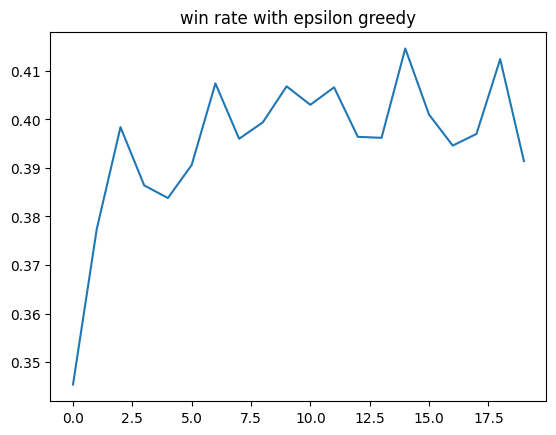

In [ ]:
play_games(env, agent_eps)
plt.plot(st)
plt.title('win rate with epsilon greedy');

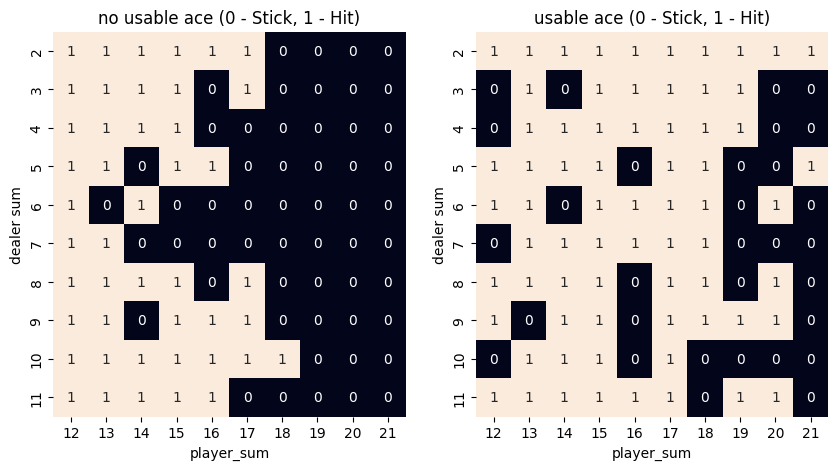

In [ ]:
visualize_q_func(agent_eps.q_table)

<p class="task" id="3"></p>

3\. Повторите решение задачи 1, используя алгоритм double Q-learning.

Cтратегия для выбора действия:
1. Сгенерировать число $p$ из $U(0, 1)$;
2. Если $p < \epsilon$, то выбрать действие случайным образом;
3. В противном случае $a_{t+1}(s_t) = argmax_a\left((Q^A_t + Q^B_t)(s_t, a))\right) $.

Правило обновления Q-функции:
$$
Q^A_{t+1}(s_{t}, a_{t}) = Q^A_{t}(s_{t}, a_{t}) + \alpha_{t}(s_{t}, a_{t}) \left(r_{t} + \gamma Q^B_{t}\left(s_{t+1}, {arg~max}_{a} Q^A_t(s_{t+1}, a)\right) - Q^A_{t}(s_{t}, a_{t})\right)
$$

$$
Q^B_{t+1}(s_{t}, a_{t}) = Q^B_{t}(s_{t}, a_{t}) + \alpha_{t}(s_{t}, a_{t}) \left(r_{t} + \gamma Q^A_{t}\left(s_{t+1}, {arg~max}_{a} Q^B_t(s_{t+1}, a)\right) - Q^B_{t}(s_{t}, a_{t})\right)
$$


- [ ] Проверено на семинаре

In [ ]:
@dataclass
class Config:
  discount: float = 0.95
  lr: float = 0.1
  n_episodes: float = 100_000
  epsilon: float = 1
  final_epsilon: float = 0.1
  print_every: int = 5000

In [ ]:
class DoubleQLearning:
    def __init__(self, env: gym.Env, config: Config):
        self.env = env
        self.config = config
        self._create_q_table()

    def _create_q_table(self):
        # напишите код для создания таблицы Q-функции
        # для окружения Blackjack должен получиться массив 32x11x2x2
        self.q_a = np.random.uniform(0, 1, size=(32, 11, 2, 2))
        self.q_b = np.random.uniform(0, 1, size=(32, 11, 2, 2))

    def eps_decay(self):
        self.eps = max(self.config.final_epsilon, self.eps - 0.05)

    def get_action(self, state: np.ndarray) -> int:
        p = np.random.uniform(0, 1)
        if p < self.eps:
          self.eps_decay()
          return self.env.action_space.sample()
        else:
          return np.argmax(self.q_a[state] + self.q_b[state])

    def update_q_table(self, state: np.ndarray, new_state: np.ndarray, reward: float, action: int, done: bool) -> None:
        # напишите код для обновления Q-функции согласно правилу выше
        # если эпизод закончен, то будущая награда равна 0
        gamma = self.config.discount
        lr = self.config.lr
        q_a_future = (not done) * self.q_a[new_state][np.argmax(self.q_b[new_state])]
        q_b_future = (not done) * self.q_b[new_state][np.argmax(self.q_a[new_state])]
        self.q_a[state][action] = self.q_a[state][action] + lr * (reward + gamma * q_b_future - self.q_a[state][action])
        self.q_b[state][action] = self.q_b[state][action] + lr * (reward + gamma * q_a_future - self.q_b[state][action])

    def run_episode(self) -> float:
        done = False
        state, info = self.env.reset()
        while not done:
            action = self.get_action(state)
            new_state, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated
            self.update_q_table(state, new_state, reward, action, done)
            state = new_state

            if done:
              return reward

    def train(self):
        # допишите код для сбора статистики
        ep_rewards = []
        stats = []
        for ep in tqdm(range(self.config.n_episodes)):
            reward = self.run_episode()
            ep_rewards.append(reward)
            if (ep+1) % self.config.print_every == 0:
                rew = np.array(ep_rewards)
                stats.append(rew[rew == 1].sum() / self.config.print_every)
                ep_rewards = []
        return stats

In [ ]:
env = gym.make('Blackjack-v1', natural=False, sab=False)

agent_double = DoubleQLearning(env, Config)
st = agent_double.train()

100%|██████████| 100000/100000 [00:21<00:00, 4600.15it/s]


winrate: 0.4221


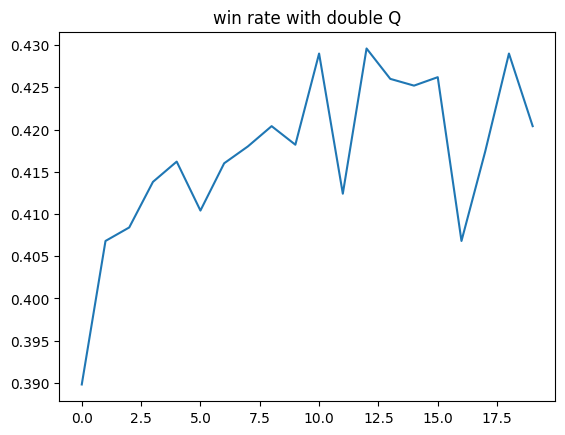

In [ ]:
play_games(env, agent_double)
plt.plot(st)
plt.title('win rate with double Q');

Q_a func


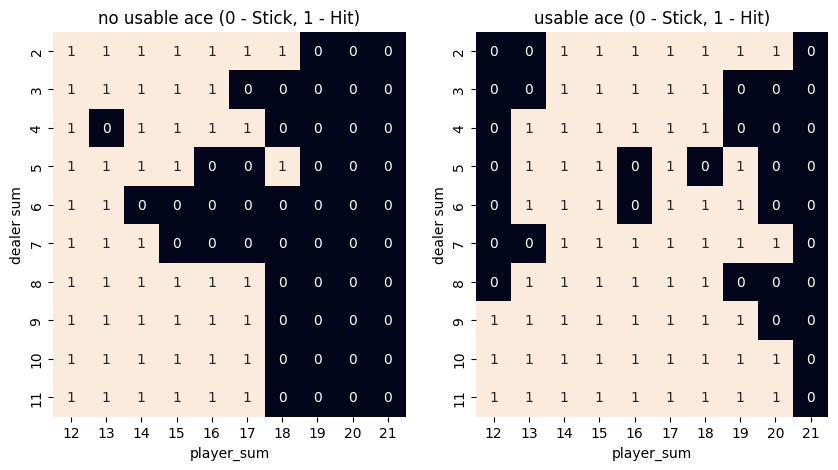

Q_b func


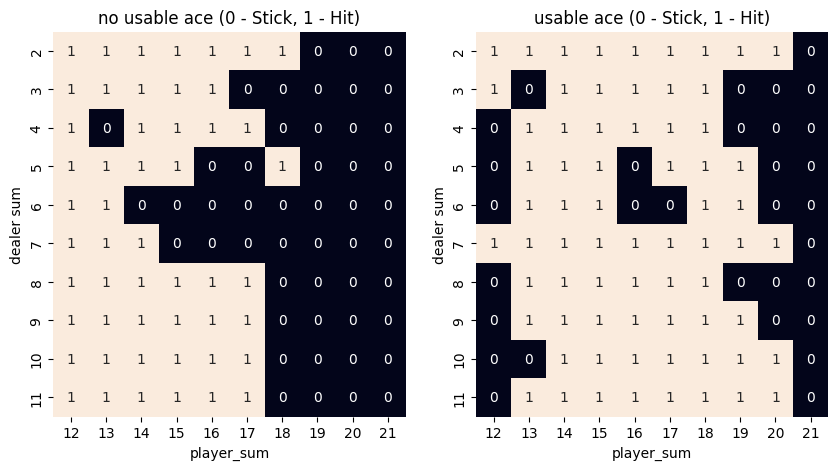

In [ ]:
print('Q_a func')
visualize_q_func(agent_double.q_a)
print('Q_b func')
visualize_q_func(agent_double.q_b)

<p class="task" id="4"></p>

4\. Обучите агента для управления машиной (окружение `MountainCar-v0`) при помощи любого из рассмотренных вариантов алгоритма Q-learning. Для перехода от непрерывного пространства состояний к конечному разбейте пространство состояний на окна (количество окон выберите сами). Для определения минимальных и максимальных значений координат воспользуйтесь [информацией об окружении](https://gymnasium.farama.org/environments/classic_control/mountain_car/#observation-space). Во время обучения несколько раз вычислите среднее значение наград за эпизод за несколько последних эпизодов и количество успешных сессий за последние эпизоды. После завершения обучения визуализируйте полученные данные.

Сделайте несколько промежуточных видео с записью работы агента во время обучения.

- [ ] Проверено на семинаре

In [ ]:
@dataclass
class Config:
  discount: float = 0.95
  lr: float = 0.1
  n_episodes: float = 20
  epsilon: float = 1
  final_epsilon: float = 0.1
  print_every: int = 5

In [ ]:
class CarAgent(DoubleQLearning):
  def __init__(self, env, Config, bins_len=[20, 20]):
    super().__init__(env, Config)
    self.bins_pos = np.linspace(-1.2, 0.6, bins_len[0])
    self.bins_vel = np.linspace(-0.7, 0.7, bins_len[1])
    self.eps = Config.epsilon

  def digitize(self, state: np.ndarray):
    pos = np.digitize(state[0], self.bins_pos)
    vel = np.digitize(state[1], self.bins_vel)
    return (pos, vel)

  def _create_q_table(self):
    self.q_a = np.zeros((20, 20, 3))
    self.q_b = np.zeros((20, 20, 3))
    # self.q_a = np.random.normal(0, 1, size=(20, 20, 3))
    # self.q_b = np.random.normal(0, 1, size=(20, 20, 3))

  def run_episode(self) -> float:
    done = False
    state, info = self.env.reset()
    state = self.digitize(state)
    while not done:
      action = self.get_action(state)
      new_state, reward, terminated, truncated, info = self.env.step(action)
      new_state = self.digitize(new_state)
      done = terminated or truncated
      self.update_q_table(state, new_state, reward, action, done)
      state = new_state

      if done:
        return reward

  def train(self):
    ep_rewards = []
    stats = []
    for ep in tqdm(range(self.config.n_episodes)):
      reward = self.run_episode()
      ep_rewards.append(reward)
      if (ep+1) % self.config.print_every == 0:
        rew = np.array(ep_rewards)
        stats.append(rew[rew == 1].sum() / self.config.print_every)
        ep_rewards = []
    return stats

In [ ]:
env = gym.make('MountainCar-v0')

car_agent = CarAgent(env, Config)
st = car_agent.train()

100%|██████████| 20/20 [00:01<00:00, 18.66it/s]


In [ ]:
st

[0.0, 0.0, 0.0, 0.0]

In [ ]:
car_agent.q_a[0, :]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [ ]:
play_games(env, car_agent)
plt.plot(st)
plt.title('win rate with double Q');

IndexError: ignored

## Обратная связь
- [ ] Хочу получить обратную связь по решению